In [1]:
import pandas as pd
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import io
import IPython.display
import pydot

import sklearn.cluster
import sklearn.preprocessing
import nltk
import sklearn.ensemble
import sklearn.decomposition
import sklearn.metrics
import sklearn.dummy
import sklearn.tree
import sklearn.svm
import sklearn.cross_validation

In [2]:
# import the csv
dirty_mathematicians = pd.read_csv('data/math_data.csv', delimiter=',', na_values=["Ph.D."])

def year_translator(x):
    if type(x) == type(""):
        try:
            return int(x)
        except ValueError:
            return 0
    return x

dirty_mathematicians['numericYear'] = dirty_mathematicians.thesisYear.map(year_translator)

# get mathematician data
mathematicians = dirty_mathematicians[(dirty_mathematicians.numericYear != 0) 
                                      & (dirty_mathematicians.numericYear.notnull())
                                     & (dirty_mathematicians.numericYear < 10000)
                                     & (dirty_mathematicians.numericYear > 1000)
                                     & (dirty_mathematicians.thesisYear.notnull())
                                     & (dirty_mathematicians.thesisUniversity.notnull())
                                     & (dirty_mathematicians.thesis.notnull())]

# Thesis title analysis


In [3]:
textblock = '\n'.join([line for line in mathematicians.thesis])
stopwords = nltk.corpus.stopwords.words('german') + \
            nltk.corpus.stopwords.words('english') + \
            nltk.corpus.stopwords.words('french') + \
            [';',',','.',':','(',')','de','la','rer','nat']
words = [word.lower() for word in nltk.word_tokenize(textblock) if word.lower() not in stopwords]
textobj = nltk.Text(words)

In [4]:
finder = nltk.collocations.BigramCollocationFinder.from_words(textobj)
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [5]:
# take the first 50 most frequent bigrams
bigrams = finder.nbest(bigram_measures.raw_freq, 50)

In [6]:
# run through the rows and see if these 2grams are in the thesis, if so plot the year.
def containsBiGram(aString, ngrams=bigrams):
    for ngram in ngrams:
        if ngram[0] in aString.lower() and ngram[1] in aString.lower():
            return True
    return False

def containsSpecificBiGram(aString, ngram):
    return ngram[0] in aString.lower() and ngram[1] in aString.lower()

def getFirstBiGram(aString, bigrams):
    for bigram in bigrams:
        if containsSpecificBiGram(aString, bigram):
            return bigram[0] + ' ' + bigram[1]
    return ""

In [29]:
# encode the bigrams
bigram_encoder = sklearn.preprocessing.LabelEncoder()
bigram_encoder.fit_transform([x[0]+' '+x[1] for x in bigrams])

# put the bigrams into strings for future use
bigrams_as_string = [' '.join(bigram) for bigram in bigrams]

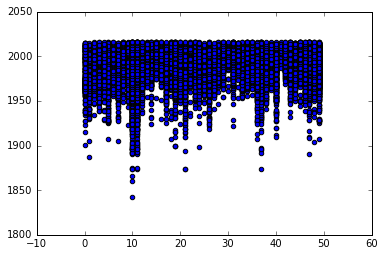

In [30]:
# plot the bigrams against year
i=0
for bigram in bigrams:
    s = mathematicians[mathematicians.thesis.map(lambda x: containsSpecificBiGram(x, bigram))].numericYear
    plt.scatter(np.array([bigram_encoder.transform(' '.join(bigram)) for x in s]), s, c='blue')
    i += 1


0  differential equations
1  partial differential
2  boundary value
3  value problems
4  time series
5  finite element
6  dynamical systems
7  banach spaces
8  optimal control
9  numerical methods
10  numerical solution
11  lie algebras
12  finite groups
13  second order
14  field theory
15  theory applications
16  ordinary differential
17  lie groups
18  limit theorems
19  integral equations


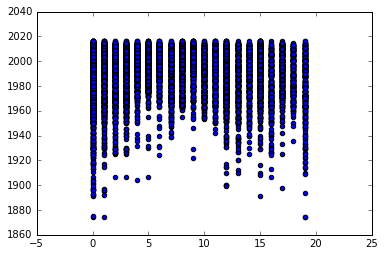

In [31]:
# plot the bigrams against year
i=0
for bigram in bigrams[0:20]:
    s = mathematicians[mathematicians.thesis.map(lambda x: containsSpecificBiGram(x, bigram))].numericYear
    plt.scatter(np.array([i for x in s]), s, c='blue')
    print(i,' ' + ' '.join(bigram))
    i += 1

## take away: bad subject classifications....

In [32]:
# put the mathematicians which contain bigrams into their own data frame:
bigramed_mathematicians = mathematicians[mathematicians.thesis.map(lambda x: containsBiGram(x, bigrams))]


In [33]:
# take the most common 1000 or 20 universities
mcUni20 = list(bigramed_mathematicians.thesisUniversity.value_counts().head(20).index)

In [34]:
# get those mathematicians with university in the mcUni2
bigramed_mathematicians=bigramed_mathematicians[bigramed_mathematicians.thesisUniversity.isin(mcUni20)]

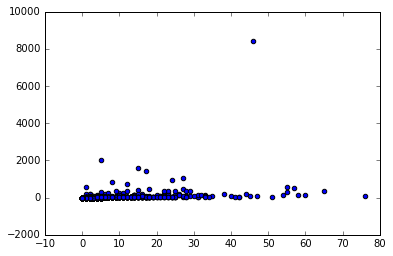

In [35]:
# there is an outlier, so I gunna remove it... ( to make K-means work! )
x=bigramed_mathematicians.numStudents
y=bigramed_mathematicians.numDescendants
plt.scatter(x,y)

# remove that outlier
bigramed_mathematicians=bigramed_mathematicians[bigramed_mathematicians.numDescendants<5000]

## K means on bigramed mathematicians

use clusterer to pick out those mathematicians that have a lot of descendants

/Users/sebastianmueller/miniconda3/lib/python3.5/site-packages/pandas/core/generic.py:2698: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


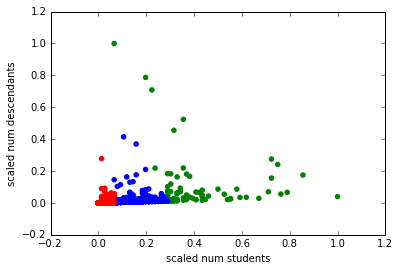

In [62]:
clusterer = sklearn.cluster.KMeans(init='k-means++', n_clusters=3)
#clusterer = sklearn.cluster.DBSCAN()

X=bigramed_mathematicians[['numStudents','numDescendants']]
max_desc=X.numDescendants.max()
max_stud=X.numStudents.max()
X.numDescendants=X.numDescendants/max_desc
X.numStudents=X.numStudents/max_stud
two_clustering = clusterer.fit_predict(X)
rainbow = np.array(['red','blue','green','orange','purple','cyan','teal'])
plt.scatter(X.numStudents, X.numDescendants, 
            color=rainbow[two_clustering])

plt.xlabel("scaled num students")
plt.ylabel("scaled num descendants")

In [63]:
# encode the clusters into the dataframe... aka the "mathematical influencer"
bigramed_mathematicians['influencer']=np.where(clusterer.fit_predict(X)>0,1,0)

## Do some one-hot encoding

In [64]:
# add one hot encoding for the thesis title bigrams
for bigram in bigrams:
    _bi = ' '.join(bigram)
    bigramed_mathematicians[_bi] = np.where(bigramed_mathematicians.thesis.map(lambda x: containsSpecificBiGram(x, bigram)),1,0)

In [65]:
# add the one hot encoding for the thesis University
for uni in mcUni20:
    bigramed_mathematicians[uni] = np.where(bigramed_mathematicians.thesisUniversity==uni, 1, 0)

In [66]:
# add labeled bigrams
bigramed_mathematicians['encoded_bigram'] = bigram_encoder.transform(bigramed_mathematicians.thesis.map(lambda x: getFirstBiGram(x, bigrams)))

In [67]:
# encode the university
uni_encoder = sklearn.preprocessing.LabelEncoder()
bigramed_mathematicians['encoded_uni']=uni_encoder.fit_transform(bigramed_mathematicians.thesisUniversity)

In [68]:
# encode the country
country_encoder = sklearn.preprocessing.LabelEncoder()
bigramed_mathematicians['encoded_country']=country_encoder.fit_transform(bigramed_mathematicians.thesisCountry)

### try predicting area of study from university and year

#### Started with Random Forest

first I didn't include the year

In [26]:
X = bigramed_mathematicians[mcUni20]
y = bigramed_mathematicians.encoded_bigram

In [27]:
classifier = sklearn.ensemble.RandomForestClassifier()
classifier.fit(X,y)
predictions = classifier.predict(X)
sklearn.metrics.accuracy_score(predictions, y)

0.12345424567188788

#### Decision Tree

In [28]:
X = bigramed_mathematicians[mcUni20+['numericYear','numStudents','numDescendants']]
y = bigramed_mathematicians.encoded_bigram

In [29]:
classifier = sklearn.tree.DecisionTreeClassifier(criterion='gini', max_depth=50)
classifier.fit(X,y)
predictions = classifier.predict(X)
sklearn.metrics.accuracy_score(predictions, y)

0.58017312448474856

#### Random Forest

In [30]:
X = bigramed_mathematicians[mcUni20+['numericYear','numStudents','numDescendants']]
y = bigramed_mathematicians.encoded_bigram

In [31]:
classifier = sklearn.ensemble.RandomForestClassifier()
classifier.fit(X,y)
predictions = classifier.predict(X)
sklearn.metrics.accuracy_score(predictions, y)

0.56883759274525969

#### SVM classifier

In [32]:
X = bigramed_mathematicians[mcUni20+['numericYear','numStudents','numDescendants']]
y = bigramed_mathematicians.encoded_bigram

In [33]:
svc = sklearn.svm.SVC(kernel='rbf')
svc.fit(X,y)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
predictions1 = classifier.predict(X)
sklearn.metrics.accuracy_score(predictions1, y)

0.56883759274525969

In [35]:
sklearn.metrics.accuracy_score(predictions,predictions1)

1.0

In [36]:
zipped_results=zip(predictions,predictions1)
sum([1 for x in zipped_results if x[0] == x[1]])

4852

do it properly with test/train split and cross_validation

In [37]:
X_train,X_test,y_train,y_test=sklearn.cross_validation.train_test_split(X,y)

In [38]:
rf=sklearn.ensemble.RandomForestClassifier()
rf.fit(X_train,y_train)
y_predict=rf.predict(X_test)
sklearn.metrics.accuracy_score(y_predict,y_test)

0.085737840065952184

In [39]:
dummy=sklearn.dummy.DummyClassifier(strategy='most_frequent')
dummy.fit(X_train,y_train)
y_predict=dummy.predict(X_test)
sklearn.metrics.accuracy_score(y_predict,y_test)

0.10222588623248145

oh no... thats not very good..

## Try predicting univeristy  from area of study and other stuff

#### Random Forests

In [41]:
X = bigramed_mathematicians[bigrams_as_string+['numericYear']]
y = bigramed_mathematicians.encoded_uni
classifier = sklearn.ensemble.RandomForestClassifier()
classifier.fit(X,y)
predictions = classifier.predict(X)
print("on itself: ", sklearn.metrics.accuracy_score(predictions, y))
X_train,X_test,y_train,y_test=sklearn.cross_validation.train_test_split(X,y)
classifier.fit(X_train, y_train)
print("cross val: ", sklearn.metrics.accuracy_score(classifier.predict(X_test),y_test))

on itself:  0.611088211047
cross val:  0.114591920857


#### SVM

In [42]:
X = bigramed_mathematicians[bigrams_as_string+['numericYear']]
y = bigramed_mathematicians.encoded_uni
classifier = sklearn.svm.SVC()
classifier.fit(X,y)
predictions = classifier.predict(X)
print("on itself: ", sklearn.metrics.accuracy_score(predictions, y))
X_train,X_test,y_train,y_test=sklearn.cross_validation.train_test_split(X,y)
classifier.fit(X_train, y_train)
print("cross val: ", sklearn.metrics.accuracy_score(classifier.predict(X_test),y_test))

on itself:  0.119126133553
cross val:  0.107996702391


#### Decision Tree

In [43]:
X = bigramed_mathematicians[bigrams_as_string+['numericYear']]
y = bigramed_mathematicians.encoded_uni
classifier = sklearn.tree.DecisionTreeClassifier(criterion='gini', max_depth=5)
classifier.fit(X,y)
predictions = classifier.predict(X)
print("on itself: ", sklearn.metrics.accuracy_score(predictions, y))
X_train,X_test,y_train,y_test=sklearn.cross_validation.train_test_split(X,y)
classifier.fit(X_train, y_train)
print("cross val: ", sklearn.metrics.accuracy_score(classifier.predict(X_test),y_test))

on itself:  0.134583676834
cross val:  0.103874690849


## Try predicting the mathematical influencers

In [75]:
# these are the features to use to predict with. Doesnt make sense to use numStudents and numDescendants here
features=mcUni20 + bigrams_as_string + ['numericYear']

#### Random Forest

In [76]:
X = bigramed_mathematicians[features]
y = bigramed_mathematicians.influencer
classifier = sklearn.ensemble.RandomForestClassifier()
classifier.fit(X,y)
predictions = classifier.predict(X)
print("on itself: ", sklearn.metrics.accuracy_score(predictions, y))
X_train,X_test,y_train,y_test=sklearn.cross_validation.train_test_split(X,y)
classifier.fit(X_train, y_train)
print("cross val: ", sklearn.metrics.accuracy_score(classifier.predict(X_test),y_test))

on itself:  0.973413025556
cross val:  0.882934872218


#### SVC

In [77]:
X = bigramed_mathematicians[features]
y = bigramed_mathematicians.influencer
classifier = sklearn.svm.SVC()
classifier.fit(X,y)
predictions = classifier.predict(X)
print("on itself: ", sklearn.metrics.accuracy_score(predictions, y))
X_train,X_test,y_train,y_test=sklearn.cross_validation.train_test_split(X,y)
classifier.fit(X_train, y_train)
print("cross val: ", sklearn.metrics.accuracy_score(classifier.predict(X_test),y_test))

on itself:  0.903751030503
cross val:  0.903544929926


#### Logistic Regression

In [78]:
X = bigramed_mathematicians[features]
y = bigramed_mathematicians.influencer
classifier = sklearn.linear_model.LogisticRegression()
classifier.fit(X,y)
predictions = classifier.predict(X)
print("on itself: ", sklearn.metrics.accuracy_score(predictions, y))
X_train,X_test,y_train,y_test=sklearn.cross_validation.train_test_split(X,y)
classifier.fit(X_train, y_train)
print("cross val: ", sklearn.metrics.accuracy_score(classifier.predict(X_test),y_test))

on itself:  0.903751030503
cross val:  0.911788953009


#### Dummy classifier

In [79]:
X = bigramed_mathematicians[features]
y = bigramed_mathematicians.influencer
classifier = sklearn.dummy.DummyClassifier(strategy='most_frequent')
classifier.fit(X,y)
predictions = classifier.predict(X)
print("on itself: ", sklearn.metrics.accuracy_score(predictions, y))
X_train,X_test,y_train,y_test=sklearn.cross_validation.train_test_split(X,y)
classifier.fit(X_train, y_train)
print("cross val: ", sklearn.metrics.accuracy_score(classifier.predict(X_test),y_test))

on itself:  0.903751030503
cross val:  0.900247320692


# K-means clustering

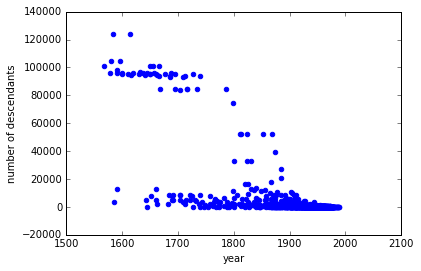

In [53]:
# a plot of year vs number of descendants
#
# as you would expect, there are several old mathematicians with huge numbers of descendants
d=mathematicians[mathematicians.numDescendants>100]
x = d.numericYear
y = d.numDescendants
plt.scatter(x,y, color='blue')
plt.xlabel('year')
plt.ylabel('number of descendants')

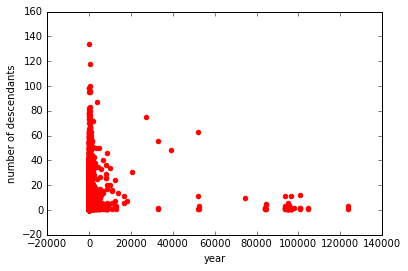

In [56]:
d=mathematicians
x = d.numDescendants
y = d.numStudents
plt.scatter(x,y, color='red')
plt.xlabel('year')
plt.ylabel('number of descendants')

# Try predicting numDescendants based on subject, year, university...

In [87]:
# add column for > 2000 descendants

In [88]:
X = bigramed_mathematicians[mcUni20+['numericYear','numStudents']]
y = bigramed_mathematicians.numDescendants

In [89]:
classifier = sklearn.svm.SVR()
classifier.fit(X,y)
predictions = classifier.predict(X)
sklearn.metrics.accuracy_score(predictions, y)

ValueError: Can't handle mix of continuous and multiclass